 This script takes the CSV output of CAEN data in coincidence mode, checks for rogue entries which are not in coincidence.  It then deletes those, computes and histograms the coincidance time.
 Finally, it performs the following modifications to the cleaned data:
  * places every 2nd line next to the previous line.  This way every line represents a single coincidence event
  * writes the modified, cleaned data into a tab separated value (TSV) file.
 
 Author:  Areg Danagoulian (aregjan@mit.edu)
 
 Date of creation: 10.09.2024
 

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Specify the file path.  Modify this for your own data
file_path = 'DataR_run_33.CSV'
#file_path = 'SDataF_run_50.CSV'

# Read the CSV file, skipping the header, and specifying the delimiter
data = np.genfromtxt(file_path, delimiter=';', skip_header=1)

# Display the contents of the numpy array
print(data)

[[0.00000000e+00 0.00000000e+00 2.30338920e+10 ... 7.50220000e+01
  1.80000000e+01            nan]
 [0.00000000e+00 0.00000000e+00 7.72589480e+10 ... 3.19019000e+02
  4.80000000e+01            nan]
 [0.00000000e+00 0.00000000e+00 7.72594720e+10 ... 3.57581000e+01
  2.20000000e+01            nan]
 ...
 [0.00000000e+00 0.00000000e+00 3.00010537e+14 ... 7.92288000e+01
  1.50000000e+01            nan]
 [0.00000000e+00 0.00000000e+00 3.00027738e+14 ... 4.45925000e+02
  5.90000000e+01            nan]
 [0.00000000e+00 0.00000000e+00 3.00064042e+14 ... 3.64593000e+01
  1.70000000e+01            nan]]


In [10]:
sorted_data = data[data[:, 2].argsort()] #sort based on time

In [11]:
#Start the search for rogue events.  Record their positions.
#IMPORTANT: remember, the time stamps are in picoseconds
rogues=0
rows_to_delete=[]
for i in range(sorted_data.shape[0]):
    if(i>0 and i<sorted_data.shape[0]-1): #for all lines except the first one and the last one
            if(abs( sorted_data[i,2]-sorted_data[i-1,2])>96e+3 and \
               abs( sorted_data[i,2]-sorted_data[i+1,2])>96e+3): #check every entry against the previous and next for coincidence of <96ns
                print("Caught a rogue entry: %i" % i)
                rows_to_delete.append(i)
                rogues+=1
#        print("%i\t %i" % (sorted_data[i][1] , (sorted_data[i][2]/1000.0)) )
print("Number of rogue entries, total: %i" % rogues)

Caught a rogue entry: 54
Caught a rogue entry: 127
Caught a rogue entry: 186
Caught a rogue entry: 291
Caught a rogue entry: 368
Caught a rogue entry: 395
Caught a rogue entry: 400
Caught a rogue entry: 555
Caught a rogue entry: 644
Caught a rogue entry: 737
Caught a rogue entry: 754
Caught a rogue entry: 809
Caught a rogue entry: 868
Caught a rogue entry: 917
Caught a rogue entry: 930
Caught a rogue entry: 957
Caught a rogue entry: 1004
Caught a rogue entry: 1035
Caught a rogue entry: 1118
Caught a rogue entry: 1211
Caught a rogue entry: 1258
Caught a rogue entry: 1455
Caught a rogue entry: 1480
Caught a rogue entry: 1491
Caught a rogue entry: 1492
Caught a rogue entry: 1735
Caught a rogue entry: 1916
Caught a rogue entry: 2187
Caught a rogue entry: 2228
Caught a rogue entry: 2301
Caught a rogue entry: 2362
Caught a rogue entry: 2415
Caught a rogue entry: 2476
Caught a rogue entry: 2627
Caught a rogue entry: 2640
Caught a rogue entry: 2755
Caught a rogue entry: 2806
Caught a rogue ent

In [12]:
clean_data = np.delete(sorted_data, rows_to_delete, axis=0) #delete the rogue entries
clean_data[0:20,2]*1e-3 #print the first twenty entries of coincidence in nanoseconds

array([2.30338800e+07, 2.30338920e+07, 7.72589480e+07, 7.72589480e+07,
       7.72594720e+07, 7.72594720e+07, 2.99792176e+08, 2.99792180e+08,
       4.87178096e+08, 4.87178108e+08, 5.03244896e+08, 5.03244920e+08,
       6.81646404e+08, 6.81646404e+08, 7.17476512e+08, 7.17476520e+08,
       8.04540200e+08, 8.04540204e+08, 8.72614820e+08, 8.72614828e+08])

In [13]:
coincidence_time=np.empty(0)
total_energy=np.empty(0) #the sum of det0+det1
for i in range(1,clean_data.shape[0],2):
#        print(i,1e-3*(clean_data[i,2]-clean_data[i-1,2]))
        coincidence_time=np.append(coincidence_time,clean_data[i,2]-clean_data[i-1,2])
        total_energy=np.append(total_energy,clean_data[i,4]+clean_data[i-1,4]) #use calibrated energy. Use col3 for uncalibrated

Text(0.5, 0, 'Coincidence time [ns]')

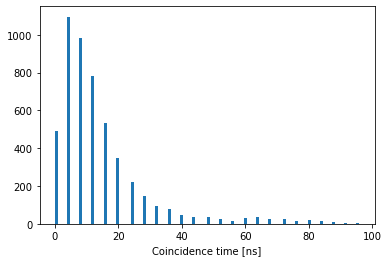

In [14]:
plt.figure(0)
plt.hist(coincidence_time*1e-3,bins=100) #multiply coincidence time by 1e-3 to convert from pico to nanosec
plt.xlabel('Coincidence time [ns]')

Text(0.5, 0, 'Det0+Det1 [keV] <-- this may be miscalibrated')

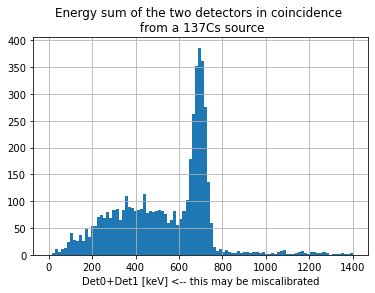

In [20]:
plt.figure(1)
plt.hist(total_energy,bins=100,range=[0,1400])
plt.title('Energy sum of the two detectors in coincidence \n from a 137Cs source')
plt.grid(True)
plt.xlabel('Det0+Det1 [keV] <-- this may be miscalibrated')

Now, let's take the clean_data, let's drop the last odd entry, and let's "reshape" it, i.e. let's palce every 2nd entry next to the previous entry.  The result should be lines which represent single coincidence events.

Save the results in a tab separated value (tsv) file for future use.

In [16]:
output_file = file_path.split('.')[0]+"_cleaned.tsv"

#clean_data might have a trailing odd number.  Delete it.
if(clean_data.shape[0]%2==1):
    print("Caught an odd entry, deleting")
    print(clean_data[-3])
    print(clean_data[-2])
    print(clean_data[-1])
    clean_data=clean_data[:-1] 
    
#take clean_data and place every 2nd row next to the previous row:    
clean_data_reshaped = clean_data.reshape(-1, 2 * clean_data.shape[1])

# Save the numpy array as a tab-separated value file
header="board\tchannel\ttime[ps]\tE\tE_calib\tE_short\tFlag\tboard\tchannel\ttime[ps]\tE\tE_calib\tE_short\tFlag"
np.savetxt(output_file, clean_data_reshaped, delimiter='\t', fmt='%0.2f',header=header)

print(f"Data saved to {output_file}")

Caught an odd entry, deleting
[0.00000000e+00 0.00000000e+00 3.00007593e+14 1.48000000e+02
 1.03769000e+02 2.30000000e+01            nan]
[0.00000000e+00 1.00000000e+00 3.00007593e+14 6.80000000e+01
 7.20460000e+01 1.40000000e+01            nan]
[0.00000000e+00 0.00000000e+00 3.00064042e+14 5.20000000e+01
 3.64593000e+01 1.70000000e+01            nan]
Data saved to DataR_run_33_cleaned.tsv
